# Fine-Tuning Gemma and Building Evals

## Introduction  

In the previous notebook, we explored using prompting techniques to classify football teams as either American or Australian. While this highlighted the power of in-context learning, we also saw its limitations: system prompts alone weren’t reliable enough for our use case.  

In this notebook, we’ll move beyond prompting and fine-tune a model — **Gemma-270M** — to improve its ability to distinguish between American and Australian teams. Fine-tuning allows us to specialize the model on our task, even when starting with small open-weight models. Along the way, we’ll also begin thinking about **evaluations (Evals)**, setting up a simple way to test model performance.  

This notebook will cover:  
- Preparing our dataset of teams for fine-tuning.  
- Running fine-tuning with Hugging Face tools.  
- Evaluating the model’s performance on held-out data.  
- Building the foundation for an evaluation harness we can extend later.  

By the end, you’ll have a fine-tuned model for football team classification and a first step toward a reproducible evaluation workflow.  

## Environment setup  

Before fine-tuning, let’s install the libraries we’ll need. This includes PyTorch, Hugging Face’s `transformers` and `datasets`, and a few extras like `trl` for training.  
If you’re running on a GPU that supports BF16 and flash attention (like an NVIDIA L4 or A100), you can also install `flash-attn` for faster training.  

In [1]:
# Install Pytorch & other libraries
%pip install torch tensorboard

# Install Hugging Face libraries
%pip install transformers datasets accelerate evaluate trl protobuf sentencepiece

# COMMENT IN: if you are running on a GPU that supports BF16 data type and flash attn, such as NVIDIA L4 or NVIDIA A100
%pip install flash-attn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.6/564.6 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 52.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for flash-attn: filename=flash_attn-2.8.3-cp312-cp312-linux_x86_64.whl size=256040057 sha256=f25da18657a87fc83dc1bfb8b7751b82246e9db355510226b674fd437c34b5fb
  Stored in directory: /root/.cache/pip/wheels/3d/59/46/f282c12c73dd4bb3c2e3fe199f1a0d0f8cec06df0cccfeee27
Successfully built flash-attn


To use open-weight models from the Hugging Face Hub, we’ll need to log in with a user access token.  
In Colab, we can securely pull the token from the environment and pass it to `huggingface_hub.login()`.  

In [3]:
from google.colab import userdata
from huggingface_hub import login

# Login into Hugging Face Hub smth
# hf_token = userdata.get('gemmaft-test2') # If you are running inside a Google Colab
hf_token = userdata.get('HF_TOKEN') # If you are running inside a Google Colab

login(hf_token)

You can keep the results on Colab's local virtual machine. However, we highly recommend saving your intermediate results to your Google Drive. This ensures your training results are safe and allows you to easily compare and select the best model.

In [7]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

## Configure fine-tuning setup  

Here we choose the base model, where to save checkpoints, and set an initial learning rate.  
We’ll keep the learning rate simple for now and revisit what it means (and how to tune it) later in the notebook.  

In [8]:
base_model = "google/gemma-3-270m-it" # @param ["google/gemma-3-270m-it","google/gemma-3-1b-it","google/gemma-3-4b-it","google/gemma-3-12b-it","google/gemma-3-27b-it"] {"allow-input":true}
checkpoint_dir = "/content/drive/MyDrive/FootballTeam" #@param {type:"string"}
learning_rate = 5e-5 #@param {type:"number"}

In [9]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained(base_model, token=hf_token)
model = AutoModelForCausalLM.from_pretrained(base_model, token=hf_token,
                                             torch_dtype="auto",
                                             device_map="auto",
                                             attn_implementation="eager")


print(f"Device: {model.device}")
print(f"DType: {model.dtype}")

tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/536M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

Device: cuda:0
DType: torch.bfloat16


## Establishing a Baseline (reuse from NB1)

Before diving into fine-tuning, we’ll start by reusing the same setup from Notebook 1:  
- Load the model and create a pipeline  
- Define a helper function for single-turn prompts  
- Run the football classification task (AFL vs NFL)  

This gives us a baseline of how **Gemma 270M performs out of the box**.  
As we’ll see, system prompting alone isn’t enough — which motivates the need for fine-tuning.  

In [10]:
from transformers import pipeline

from random import randint
import re

# Load the model and tokenizer into the pipeline
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)

messages = [
    {"role": "user", "content": "What is your name"}
]


# Convert as test example into a prompt with the Gemma template
prompt = pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True, return_full_text=False)
outputs = pipe(prompt, max_new_tokens=256,
               disable_compile=True,
               return_full_text=False)

outputs[0]["generated_text"]

Device set to use cuda:0


'I am Gemma, an open-weights Gemma. I am a large language model created by the Gemma team at Google DeepMind.\n'

In [11]:
def single_turn(prompt, pipeline):
  messages = [
    {"role": "user", "content": prompt}
  ]

  prompt = pipe.tokenizer.apply_chat_template(messages,
                                              tokenize=False,
                                              add_generation_prompt=True,
                                              return_full_text=False)
  outputs = pipe(prompt,
                max_new_tokens=256,
               disable_compile=True,
               return_full_text=False)

  return outputs[0]["generated_text"]
single_turn("What is your name?", pipeline)

'I am Gemma, a large language model created by the Gemma team at Google DeepMind.'

In [12]:
afl_clubs = [
    "Adelaide Crows",
    "Brisbane Lions",
    "Carlton Blues",
    "Collingwood Magpies",
    "Essendon Bombers",
    "Fremantle Dockers",
    "Geelong Cats",
    "Gold Coast Suns",
    "Greater Western Sydney (GWS) Giants",
    "Hawthorn Hawks",
    "Melbourne Demons",
    "North Melbourne Kangaroos",
    "Port Adelaide Power",
    "Richmond Tigers",
    "St Kilda Saints",
    "Sydney Swans",
    "West Coast Eagles",
    "Western Bulldogs"
]

nfl_teams = [
    "Arizona Cardinals",
    "Atlanta Falcons",
    "Baltimore Ravens",
    "Buffalo Bills",
    "Carolina Panthers",
    "Chicago Bears",
    "Cincinnati Bengals",
    "Cleveland Browns",
    "Dallas Cowboys",
    "Denver Broncos",
    "Detroit Lions",
    "Green Bay Packers",
    "Houston Texans",
    "Indianapolis Colts",
    "Jacksonville Jaguars",
    "Kansas City Chiefs",
    "Las Vegas Raiders",
    "Los Angeles Chargers",
    "Los Angeles Rams",
    "Miami Dolphins",
    "Minnesota Vikings",
    "New England Patriots",
    "New Orleans Saints",
    "New York Giants",
    "New York Jets",
    "Philadelphia Eagles",
    "Pittsburgh Steelers",
    "San Francisco 49ers",
    "Seattle Seahawks",
    "Tampa Bay Buccaneers",
    "Tennessee Titans",
    "Washington Commanders"
]

In [13]:
import numpy as np
eval_map = {"australian": afl_clubs, "american": nfl_teams}

score = []
for nationality, teams in eval_map.items():
    for team in teams:
        prompt = f"Output if this is an australian or american team, only print australian or american no other output: {team}"
        response = single_turn(prompt, pipeline).strip()
        score.append(response.lower() == nationality)
        print(f"{team}: {response}")

print(np.array(score).mean())

Adelaide Crows: Okay, I'm ready.
Brisbane Lions: Brisbane Lions
Carlton Blues: 
Collingwood Magpies: Collingwood Magpies
Essendon Bombers: Essendon Bombers
Fremantle Dockers: Fremantle Dockers
Geelong Cats: Geelong Cats


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Gold Coast Suns: Gold Coast Suns
Greater Western Sydney (GWS) Giants: Greater Western Sydney (GWS) Giants
Hawthorn Hawks: Hawthorn Hawks
Melbourne Demons: Melbourne Demons
North Melbourne Kangaroos: North Melbourne Kangaroos
Port Adelaide Power: Port Adelaide Power
Richmond Tigers: Richmond Tigers
St Kilda Saints: 
Sydney Swans: Sydney Swans
West Coast Eagles: West Coast Eagles
Western Bulldogs: West Bulldogs
Arizona Cardinals: Arizona Cardinals
Atlanta Falcons: Atlanta Falcons
Baltimore Ravens: Baltimore Ravens
Buffalo Bills: Buffalo Bills
Carolina Panthers: Carolina Panthers
Chicago Bears: Chicago Bears
Cincinnati Bengals: Cincinnati Bengals
Cleveland Browns: Cleveland Browns
Dallas Cowboys: Dallas Cowboys
Denver Broncos: Denver Broncos
Detroit Lions: Detroit Lions
Green Bay Packers: Green Bay Packers
Houston Texans: Houston Texans
Indianapolis Colts: Indianapolis Colts
Jacksonville Jaguars: Okay, I understand.
Kansas City Chiefs: Kansas City Chiefs
Las Vegas Raiders: Las Vegas Raide

In this run, we tried to classify sports teams as AFL (Australian) or NFL (American) using only a system prompt.  
The model wasn’t able to do this reliably: many outputs were incorrect or inconsistent.  

This illustrates the limits of **system prompting** for small models in a classification setting.  
Next, we’ll explore fine-tuning, which gives the model a stronger grounding in the task.  

## Fine Tuning

Now we prepare the training data.
Each team name is paired with the correct label (Australian or American) and wrapped into a conversational format (user prompt + assistant response).
We then create a Hugging Face Dataset from these samples and split it into training and test sets, ready for fine-tuning.

In [14]:
from datasets import Dataset

def create_conversation(sample):
  return {
      "messages": [
          {"role": "user", "content": sample["prompt"]},
          {"role": "assistant", "content": f'{sample["nationality"]}'}
      ]
  }



data_samples = []
for nationality, teams in eval_map.items():
    for team in teams:
        prompt = f"Output if this is an australian or american team, only print australian or american no other output: {team}"
        data_samples.append({"prompt": prompt, "nationality": nationality})

# Create a Hugging Face Dataset from the list of dictionaries
dataset_from_strings = Dataset.from_list(data_samples)


# Create a Hugging Face Dataset from the list of dictionaries
dataset_from_strings = Dataset.from_list(data_samples)

# Convert dataset to conversational format
dataset = dataset_from_strings.map(create_conversation, remove_columns=dataset_from_strings.features, batched=False)

# Split dataset into 80% training samples and 20% test samples
dataset = dataset.train_test_split(test_size=0.2, shuffle=False)

# Print a formatted user prompt from the new dataset
print(dataset["train"][0]["messages"])

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

[{'content': 'Output if this is an australian or american team, only print australian or american no other output: Adelaide Crows', 'role': 'user'}, {'content': 'australian', 'role': 'assistant'}]


## Training

Now it’s time to fine-tune. Before we can start the training process, we need to define the key hyperparameters that will control how fine-tuning runs. We do this by creating an `SFTConfig` instance, which holds settings like the number of epochs, batch size, learning rate, and how often to save checkpoints.

For those who haven’t had much experience with deep learning, you’ll notice a few terms here. You can think of these as *hyperparameters* — settings you tune in order to optimize the training process:  

- **Learning rate** – how big a step the model takes when updating its knowledge.  
- **Number of epochs** – how many times the model sees the entire training data.  
- **Batch size** – how many examples the model processes at once before updating.  
- **Optimizer** – the algorithm that updates the model weights; `Adam` (or its variants) is a strong default for most cases.  


We'll chat more about these and provide intuition behind them soon!




In [15]:
from trl import SFTConfig

torch_dtype = model.dtype

args = SFTConfig(
    output_dir=checkpoint_dir,              # directory to save and repository id
    max_length=512,                         # max sequence length for model and packing of the dataset
    packing=False,                          # Groups multiple samples in the dataset into a single sequence
    num_train_epochs=5,                     # number of training epochs
    per_device_train_batch_size=4,          # batch size per device during training
    gradient_checkpointing=False,           # Caching is incompatible with gradient checkpointing
    optim="adamw_torch_fused",              # use fused adamw optimizer
    logging_steps=1,                        # log every step
    save_strategy="epoch",                  # save checkpoint every epoch
    eval_strategy="epoch",                  # evaluate checkpoint every epoch
    learning_rate=learning_rate,            # learning rate
    fp16=True if torch_dtype == torch.float16 else False,   # use float16 precision
    bf16=True if torch_dtype == torch.bfloat16 else False,  # use bfloat16 precisionssmth
    lr_scheduler_type="constant",           # use constant learning rate scheduler
    push_to_hub=False,                       # push model to hub
    report_to="tensorboard",                # report metrics to tensorboard
    dataset_kwargs={
        "add_special_tokens": False, # Template with special tokens
        "append_concat_token": True, # Add EOS token as separator token between examples
    }
)

With our configuration defined, we’re ready to bring everything together.  
The next step is to create a `Trainer` object, which handles the full training loop for us: applying our hyperparameters, running through the training and evaluation datasets, and keeping track of progress.  

In [16]:
from trl import SFTTrainer

# Create Trainer object
trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    processing_class=tokenizer,
    #token=hf_token
)

Tokenizing train dataset:   0%|          | 0/40 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/40 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/10 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/10 [00:00<?, ? examples/s]

Now that the `Trainer` is set up, the final step is to kick off the training run.  
This is where the model actually fine-tunes on your dataset, and you’ll see key metrics like loss and accuracy update for each epoch:

When training starts, you’ll see a few key metrics reported:  

- **Training Loss** – how well the model is fitting your training data (lower is better).  
- **Validation Loss** – performance on held-out data, helps spot overfitting.  
- **Entropy** – a measure of prediction uncertainty (lower means the model is more confident).  
- **Num Tokens** – how many tokens have been processed so far.  
- **Mean Token Accuracy** – fraction of tokens predicted correctly (higher is better).  



In [17]:
# Start training, the model will be automatically saved to the Hub and the output directory
trainer.train()

# Save the final model again to the Hugging Face Hub (if desired)
# trainer.save_model()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': 2, 'pad_token_id': 0}.


Epoch,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
1,0.630300,0.541956,0.553835,1443.000000,0.923950
2,0.349600,0.483107,0.493242,2886.000000,0.949370
3,0.170300,0.405235,0.170166,4329.000000,0.952941
4,0.180500,0.349541,0.192300,5772.000000,0.951155
5,0.214700,0.353016,0.152668,7215.000000,0.951155


TrainOutput(global_step=50, training_loss=0.6558457662165165, metrics={'train_runtime': 398.6774, 'train_samples_per_second': 0.502, 'train_steps_per_second': 0.125, 'total_flos': 4507447246848.0, 'train_loss': 0.6558457662165165, 'epoch': 5.0})

We can also visualize how training is progressing by plotting the **training loss** and **validation loss** across epochs.  
This helps us see whether the model is learning effectively and if it’s starting to overfit.

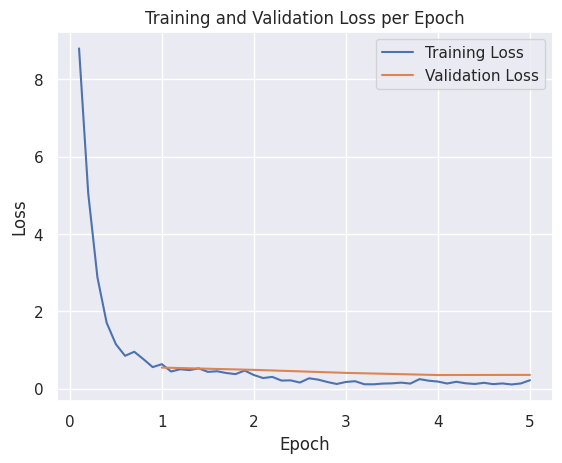

In [18]:
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

# Access the log history
log_history = trainer.state.log_history

# Extract training / validation loss
train_losses = [log["loss"] for log in log_history if "loss" in log]
epoch_train = [log["epoch"] for log in log_history if "loss" in log]
eval_losses = [log["eval_loss"] for log in log_history if "eval_loss" in log]
epoch_eval = [log["epoch"] for log in log_history if "eval_loss" in log]

# Plot the training loss
plt.plot(epoch_train, train_losses, label="Training Loss")
plt.plot(epoch_eval, eval_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

From the plot, we see that both training and validation loss decrease rapidly at first, then level off.  
- This indicates the model is learning and converging.  
- The validation loss stays close to training loss, suggesting limited overfitting.  
- If validation loss started increasing while training loss kept falling, that would be a warning sign of overfitting.  

## Test Model Inference and rerun eval

Now that training is complete, let’s reload the fine-tuned model and tokenizer from the checkpoint directory.  

This ensures we’re evaluating the latest trained weights.


In [19]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_id = checkpoint_dir

# Load Model
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype="auto",
    device_map="auto",
    attn_implementation="eager"
)
tokenizer = AutoTokenizer.from_pretrained(model_id)

ValueError: Unrecognized model in /content/drive/MyDrive/FootballTeam. Should have a `model_type` key in its config.json, or contain one of the following strings in its name: aimv2, aimv2_vision_model, albert, align, altclip, apertus, arcee, aria, aria_text, audio-spectrogram-transformer, autoformer, aya_vision, bamba, bark, bart, beit, bert, bert-generation, big_bird, bigbird_pegasus, biogpt, bit, bitnet, blenderbot, blenderbot-small, blip, blip-2, blip_2_qformer, bloom, bridgetower, bros, camembert, canine, chameleon, chinese_clip, chinese_clip_vision_model, clap, clip, clip_text_model, clip_vision_model, clipseg, clvp, code_llama, codegen, cohere, cohere2, cohere2_vision, colpali, colqwen2, conditional_detr, convbert, convnext, convnextv2, cpmant, csm, ctrl, cvt, d_fine, dab-detr, dac, data2vec-audio, data2vec-text, data2vec-vision, dbrx, deberta, deberta-v2, decision_transformer, deepseek_v2, deepseek_v3, deepseek_vl, deepseek_vl_hybrid, deformable_detr, deit, depth_anything, depth_pro, deta, detr, dia, diffllama, dinat, dinov2, dinov2_with_registers, dinov3_convnext, dinov3_vit, distilbert, doge, donut-swin, dots1, dpr, dpt, efficientformer, efficientloftr, efficientnet, electra, emu3, encodec, encoder-decoder, eomt, ernie, ernie4_5, ernie4_5_moe, ernie_m, esm, evolla, exaone4, falcon, falcon_h1, falcon_mamba, fastspeech2_conformer, fastspeech2_conformer_with_hifigan, flaubert, flava, florence2, fnet, focalnet, fsmt, funnel, fuyu, gemma, gemma2, gemma3, gemma3_text, gemma3n, gemma3n_audio, gemma3n_text, gemma3n_vision, git, glm, glm4, glm4_moe, glm4v, glm4v_moe, glm4v_moe_text, glm4v_text, glpn, got_ocr2, gpt-sw3, gpt2, gpt_bigcode, gpt_neo, gpt_neox, gpt_neox_japanese, gpt_oss, gptj, gptsan-japanese, granite, granite_speech, granitemoe, granitemoehybrid, granitemoeshared, granitevision, graphormer, grounding-dino, groupvit, helium, hgnet_v2, hiera, hubert, hunyuan_v1_dense, hunyuan_v1_moe, ibert, idefics, idefics2, idefics3, idefics3_vision, ijepa, imagegpt, informer, instructblip, instructblipvideo, internvl, internvl_vision, jamba, janus, jetmoe, jukebox, kosmos-2, kosmos-2.5, kyutai_speech_to_text, layoutlm, layoutlmv2, layoutlmv3, led, levit, lfm2, lightglue, lilt, llama, llama4, llama4_text, llava, llava_next, llava_next_video, llava_onevision, longformer, longt5, luke, lxmert, m2m_100, mamba, mamba2, marian, markuplm, mask2former, maskformer, maskformer-swin, mbart, mctct, mega, megatron-bert, metaclip_2, mgp-str, mimi, minimax, mistral, mistral3, mixtral, mlcd, mllama, mm-grounding-dino, mobilebert, mobilenet_v1, mobilenet_v2, mobilevit, mobilevitv2, modernbert, modernbert-decoder, moonshine, moshi, mpnet, mpt, mra, mt5, musicgen, musicgen_melody, mvp, nat, nemotron, nezha, nllb-moe, nougat, nystromformer, olmo, olmo2, olmoe, omdet-turbo, oneformer, open-llama, openai-gpt, opt, ovis2, owlv2, owlvit, paligemma, patchtsmixer, patchtst, pegasus, pegasus_x, perceiver, perception_encoder, perception_lm, persimmon, phi, phi3, phi4_multimodal, phimoe, pix2struct, pixtral, plbart, poolformer, pop2piano, prompt_depth_anything, prophetnet, pvt, pvt_v2, qdqbert, qwen2, qwen2_5_omni, qwen2_5_vl, qwen2_5_vl_text, qwen2_audio, qwen2_audio_encoder, qwen2_moe, qwen2_vl, qwen2_vl_text, qwen3, qwen3_moe, rag, realm, recurrent_gemma, reformer, regnet, rembert, resnet, retribert, roberta, roberta-prelayernorm, roc_bert, roformer, rt_detr, rt_detr_resnet, rt_detr_v2, rwkv, sam, sam2, sam2_hiera_det_model, sam2_video, sam2_vision_model, sam_hq, sam_hq_vision_model, sam_vision_model, seamless_m4t, seamless_m4t_v2, seed_oss, segformer, seggpt, sew, sew-d, shieldgemma2, siglip, siglip2, siglip_vision_model, smollm3, smolvlm, smolvlm_vision, speech-encoder-decoder, speech_to_text, speech_to_text_2, speecht5, splinter, squeezebert, stablelm, starcoder2, superglue, superpoint, swiftformer, swin, swin2sr, swinv2, switch_transformers, t5, t5gemma, table-transformer, tapas, textnet, time_series_transformer, timesfm, timesformer, timm_backbone, timm_wrapper, trajectory_transformer, transfo-xl, trocr, tvlt, tvp, udop, umt5, unispeech, unispeech-sat, univnet, upernet, van, video_llava, videomae, vilt, vipllava, vision-encoder-decoder, vision-text-dual-encoder, visual_bert, vit, vit_hybrid, vit_mae, vit_msn, vitdet, vitmatte, vitpose, vitpose_backbone, vits, vivit, vjepa2, voxtral, voxtral_encoder, wav2vec2, wav2vec2-bert, wav2vec2-conformer, wavlm, whisper, xclip, xcodec, xglm, xlm, xlm-prophetnet, xlm-roberta, xlm-roberta-xl, xlnet, xlstm, xmod, yolos, yoso, zamba, zamba2, zoedepth

We can wrap the model and tokenizer in a Hugging Face `pipeline` to make inference easier.  
Then, we’ll rerun evaluation on our custom task to see how well the fine-tuned model performs.  

In [20]:
from transformers import pipeline

# Load the model and tokenizer into the pipeline
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)

score = []
for nationality, teams in eval_map.items():
    for team in teams:
        prompt = f"Output if this is an australian or american team, only print australian or american no other output: {team}"
        response = single_turn(prompt, pipe).strip()
        score.append(response.lower() == nationality)
        print(f"{team}: {response}")



Device set to use cuda:0


Adelaide Crows: australian
Brisbane Lions: australian
Carlton Blues: australian
Collingwood Magpies: australian
Essendon Bombers: australian
Fremantle Dockers: australian
Geelong Cats: australian
Gold Coast Suns: australian
Greater Western Sydney (GWS) Giants: australian
Hawthorn Hawks: australian
Melbourne Demons: australian
North Melbourne Kangaroos: australian
Port Adelaide Power: australian
Richmond Tigers: australian
St Kilda Saints: australian
Sydney Swans: australian
West Coast Eagles: australian
Western Bulldogs: australian
Arizona Cardinals: american
Atlanta Falcons: american
Baltimore Ravens: american
Buffalo Bills: american
Carolina Panthers: american
Chicago Bears: american
Cincinnati Bengals: american
Cleveland Browns: american
Dallas Cowboys: american
Denver Broncos: american
Detroit Lions: american
Green Bay Packers: american
Houston Texans: american
Indianapolis Colts: american
Jacksonville Jaguars: american
Kansas City Chiefs: american
Las Vegas Raiders: american
Los A

Here we’re checking whether the model correctly identifies teams as Australian or American.  
- Each team name is passed through the model with a prompt.  
- The model’s output is compared against the ground truth nationality.  
- This gives us a quick sanity check on whether fine-tuning improved the model’s behavior.  

Now let’s see how the fine-tuned model actually performs. We’ll compute the average score across all examples to measure accuracy.”

In [21]:
# Substantially better!
print(np.array(score).mean())

0.98


A score of 0.98 means the model is now getting 98% of the classifications correct: a substantial improvement that confirms fine-tuning helped.

## Summary  

In this notebook, we fine-tuned **Gemma-270M** to classify football teams as American or Australian. Compared to the first notebook, where we relied on prompting, fine-tuning gave us a more reliable and task-specific model.  

We also introduced the idea of **evaluations (Evals)**. Here, our evaluation was simple — a test set to measure accuracy — but the same principles can be extended into a more robust evaluation harness in production.  

Key takeaways:  
- Fine-tuning can overcome the limitations of system prompting for specialized tasks.  
- Even small open-weight models can be adapted effectively with the right dataset.  
- Evaluations provide a structured way to measure progress and set up reproducibility.  

Together, these steps move us closer to building reliable, production-ready generative AI systems.  